## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

## Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

python(27088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27098) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27104) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27111) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27113) Malloc

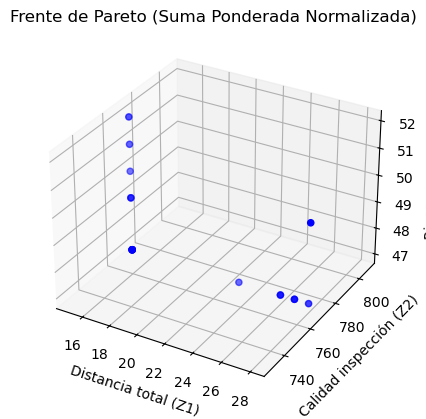

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
def read_cost_matrix_csv(filename):
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) 
        data = list(reader)
    return np.array(data, dtype=int)

cost_matrix = read_cost_matrix_csv('cost_matrix_10_nodes_1.5_spread.csv')
num_nodos = len(cost_matrix)
nodos = range(num_nodos)
equipos = range(1)

calidad_inspeccion = {
    1: 85, 2: 92, 3: 78, 4: 90, 5: 82,
    6: 88, 7: 95, 8: 75, 9: 84
}

riesgo_datos = {
    (0, 1): 3, (0, 2): 2, (0, 3): 4, (0, 4): 5,
    (0, 5): 6, (0, 6): 3, (0, 7): 2, (0, 8): 4, (0, 9): 5,
    (2, 8): 9, (2, 9): 8, (3, 4): 5, (4, 9): 7,
    (5, 6): 7, (8, 9): 7
}
riesgo_arcos = {(i, j): riesgo_datos.get((i, j), 5) for i in nodos for j in nodos if i != j}

# === Calcular extremos ===
def calcular_extremos_objetivos():
    extremos = {}

    def restricciones_base(model):
        def visit_once(model, j):
            if j != 0:
                return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
            return Constraint.Skip
        model.visit_once = Constraint(model.N, rule=visit_once)

        def salida_deposito(model, k):
            return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
        model.salida = Constraint(model.K, rule=salida_deposito)

        def entrada_deposito(model, k):
            return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
        model.entrada = Constraint(model.K, rule=entrada_deposito)

        def flujo(model, i, k):
            if i != 0:
                return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
            return Constraint.Skip
        model.flujo = Constraint(model.N, model.K, rule=flujo)

        def mtz_rule(model, i, j, k):
            if i != 0 and j != 0 and i != j:
                return model.u[i, k] - model.u[j, k] + num_nodos * model.x[i, j, k] <= num_nodos - 1
            return Constraint.Skip
        model.subtours = Constraint(model.N, model.N, model.K, rule=mtz_rule)

    for nombre, expr, sentido in [
        ('z1', lambda m: sum(m.x[i, j, k] * cost_matrix[i][j]
                             for i in m.N for j in m.N if i != j for k in m.K), minimize),
        ('z2', lambda m: sum(calidad_inspeccion.get(j, 0) *
                             sum(m.x[i, j, k] for i in m.N if i != j for k in m.K)
                             for j in m.N if j != 0), maximize),
        ('z3', lambda m: sum(m.x[i, j, k] * riesgo_arcos[i, j]
                             for i in m.N for j in m.N if i != j for k in m.K), minimize)
    ]:
        model = ConcreteModel()
        model.N = Set(initialize=nodos)
        model.K = Set(initialize=equipos)
        model.x = Var(model.N, model.N, model.K, domain=Binary)
        model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, num_nodos - 1))
        z = expr(model)
        model.Obj = Objective(expr=z, sense=sentido)
        restricciones_base(model)
        SolverFactory('glpk').solve(model)
        extremos[nombre] = value(z)

    return extremos

extremos = calcular_extremos_objetivos()
z1_min = extremos['z1']
z2_max = extremos['z2']
z3_min = extremos['z3']

z1_vec, z2_vec, z3_vec = [], [], []

w_vals = np.linspace(0, 1, 7)
peso_combinaciones = [(w1, w2, 1 - w1 - w2)
                      for w1 in w_vals for w2 in w_vals if w1 + w2 <= 1]

for w1, w2, w3 in peso_combinaciones:
    model = ConcreteModel()
    model.N = Set(initialize=nodos)
    model.K = Set(initialize=equipos)
    model.x = Var(model.N, model.N, model.K, domain=Binary)
    model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, num_nodos - 1))

    z1 = sum(model.x[i, j, k] * cost_matrix[i][j]
             for i in model.N for j in model.N if i != j for k in model.K)

    z2_real = sum(calidad_inspeccion.get(j, 0) *
                  sum(model.x[i, j, k] for i in model.N if i != j for k in model.K)
                  for j in model.N if j != 0)

    z3 = sum(model.x[i, j, k] * riesgo_arcos[i, j]
             for i in model.N for j in model.N if i != j for k in model.K)

    # Normalización
    z1_norm = (z1 - z1_min) / z1_min
    z2_norm = 1 - (z2_real / z2_max)
    z3_norm = (z3 - z3_min) / z3_min

    model.Obj = Objective(expr=w1 * z1_norm + w2 * z2_norm + w3 * z3_norm, sense=minimize)

    # Restricciones base
    def visit_once(model, j):
        if j != 0:
            return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
        return Constraint.Skip
    model.visit_once = Constraint(model.N, rule=visit_once)

    def salida_deposito(model, k):
        return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
    model.salida = Constraint(model.K, rule=salida_deposito)

    def entrada_deposito(model, k):
        return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
    model.entrada = Constraint(model.K, rule=entrada_deposito)

    def flujo(model, i, k):
        if i != 0:
            return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
        return Constraint.Skip
    model.flujo = Constraint(model.N, model.K, rule=flujo)

    def mtz_rule(model, i, j, k):
        if i != 0 and j != 0 and i != j:
            return model.u[i, k] - model.u[j, k] + num_nodos * model.x[i, j, k] <= num_nodos - 1
        return Constraint.Skip
    model.subtours = Constraint(model.N, model.N, model.K, rule=mtz_rule)

    SolverFactory('glpk').solve(model)

    z1_vec.append(value(z1))
    z2_vec.append(value(z2_real))
    z3_vec.append(value(z3))

# === Visualización ===
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z1_vec, z2_vec, z3_vec, c='blue', marker='o')
ax.set_xlabel('Distancia total (Z1)')
ax.set_ylabel('Calidad inspección (Z2)')
ax.set_zlabel('Riesgo total (Z3)')
plt.title('Frente de Pareto (Suma Ponderada Normalizada)')
plt.grid(True)
plt.show()
